# Visual Question Answering on Tables &#x1F60E;
The goal for this notebook is to show how to apply Visual Question Answering on tables.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/webinar/webinars/VisualQuestionAnsweringOnTables.ipynb)



### Colab Setup

In [2]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [4]:
# Installing Spark OCR
!pip install --upgrade -q spark-ocr==$OCR_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nlu 4.0.1rc4 requires spark-nlp<4.3.0,>=4.2.0, but you have spark-nlp 4.3.0 which is incompatible.
jsl-tmp 4.2.3rc15 requires pyspark==3.1.2, but you have pyspark 3.2.1 which is incompatible.
jsl-tmp 4.2.3rc15 requires spark-nlp==4.2.2, but you have spark-nlp 4.3.0 which is incompatible.
johnsnowlabs 4.2.5 requires pyspark==3.1.2, but you have pyspark 3.2.1 which is incompatible.
johnsnowlabs 4.2.5 requires spark-nlp==4.2.4, but you have spark-nlp 4.3.0 which is incompatible.
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.


### Initialize Spark session

In [5]:
from sparkocr import start
import pkg_resources
from pyspark import SparkConf
from pyspark.ml import PipelineModel
import os

from sparkocr.transformers import *
from sparkocr.utils import display_images, display_table, display_tables
from sparkocr.enums import *


params = {"spark.driver.memory":"16G",
"spark.kryoserializer.buffer.max":"2000M",
"spark.driver.maxResultSize":"2000M"}

spark = start(license_keys['SPARK_OCR_SECRET'], extra_conf=params)
spark

Spark version: 3.2.1
Spark NLP version: 4.2.4
Spark NLP for Healthcare version: 4.3.0
Spark OCR version: 4.3.1



RuntimeError: Java gateway process exited before sending its port number

## Load test documents

In [ ]:
# Taken from https://www2.asx.com.au/markets/trade-our-cash-market/announcements.rff
test_image_path = "./financial/*.pdf"
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.select("path").show(truncate=False)

In [4]:
pdf_to_image = PdfToImage() \
        .setInputCol("content") \
        .setOutputCol("image") \
        .setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector \
        .pretrained("general_model_table_detection_v2", "en", "clinical/ocr") \
        .setInputCol("image") \
        .setOutputCol("regions") \
        .setScoreThreshold(0.9) \
        .setApplyCorrection(False)

draw_regions = ImageDrawRegions() \
        .setInputCol("image") \
        .setInputRegionsCol("regions") \
        .setOutputCol("image_with_regions") \
        .setRectColor(Color.red)

pipeline = PipelineModel(stages=[
    pdf_to_image,
    table_detector,
    draw_regions
])

result = pipeline.transform(bin_df.limit(1)).cache()

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB



    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/webinars/financial/02567277.pdf
    Resolution: 0 dpi
    Width: 2480 px
    Height: 3508 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


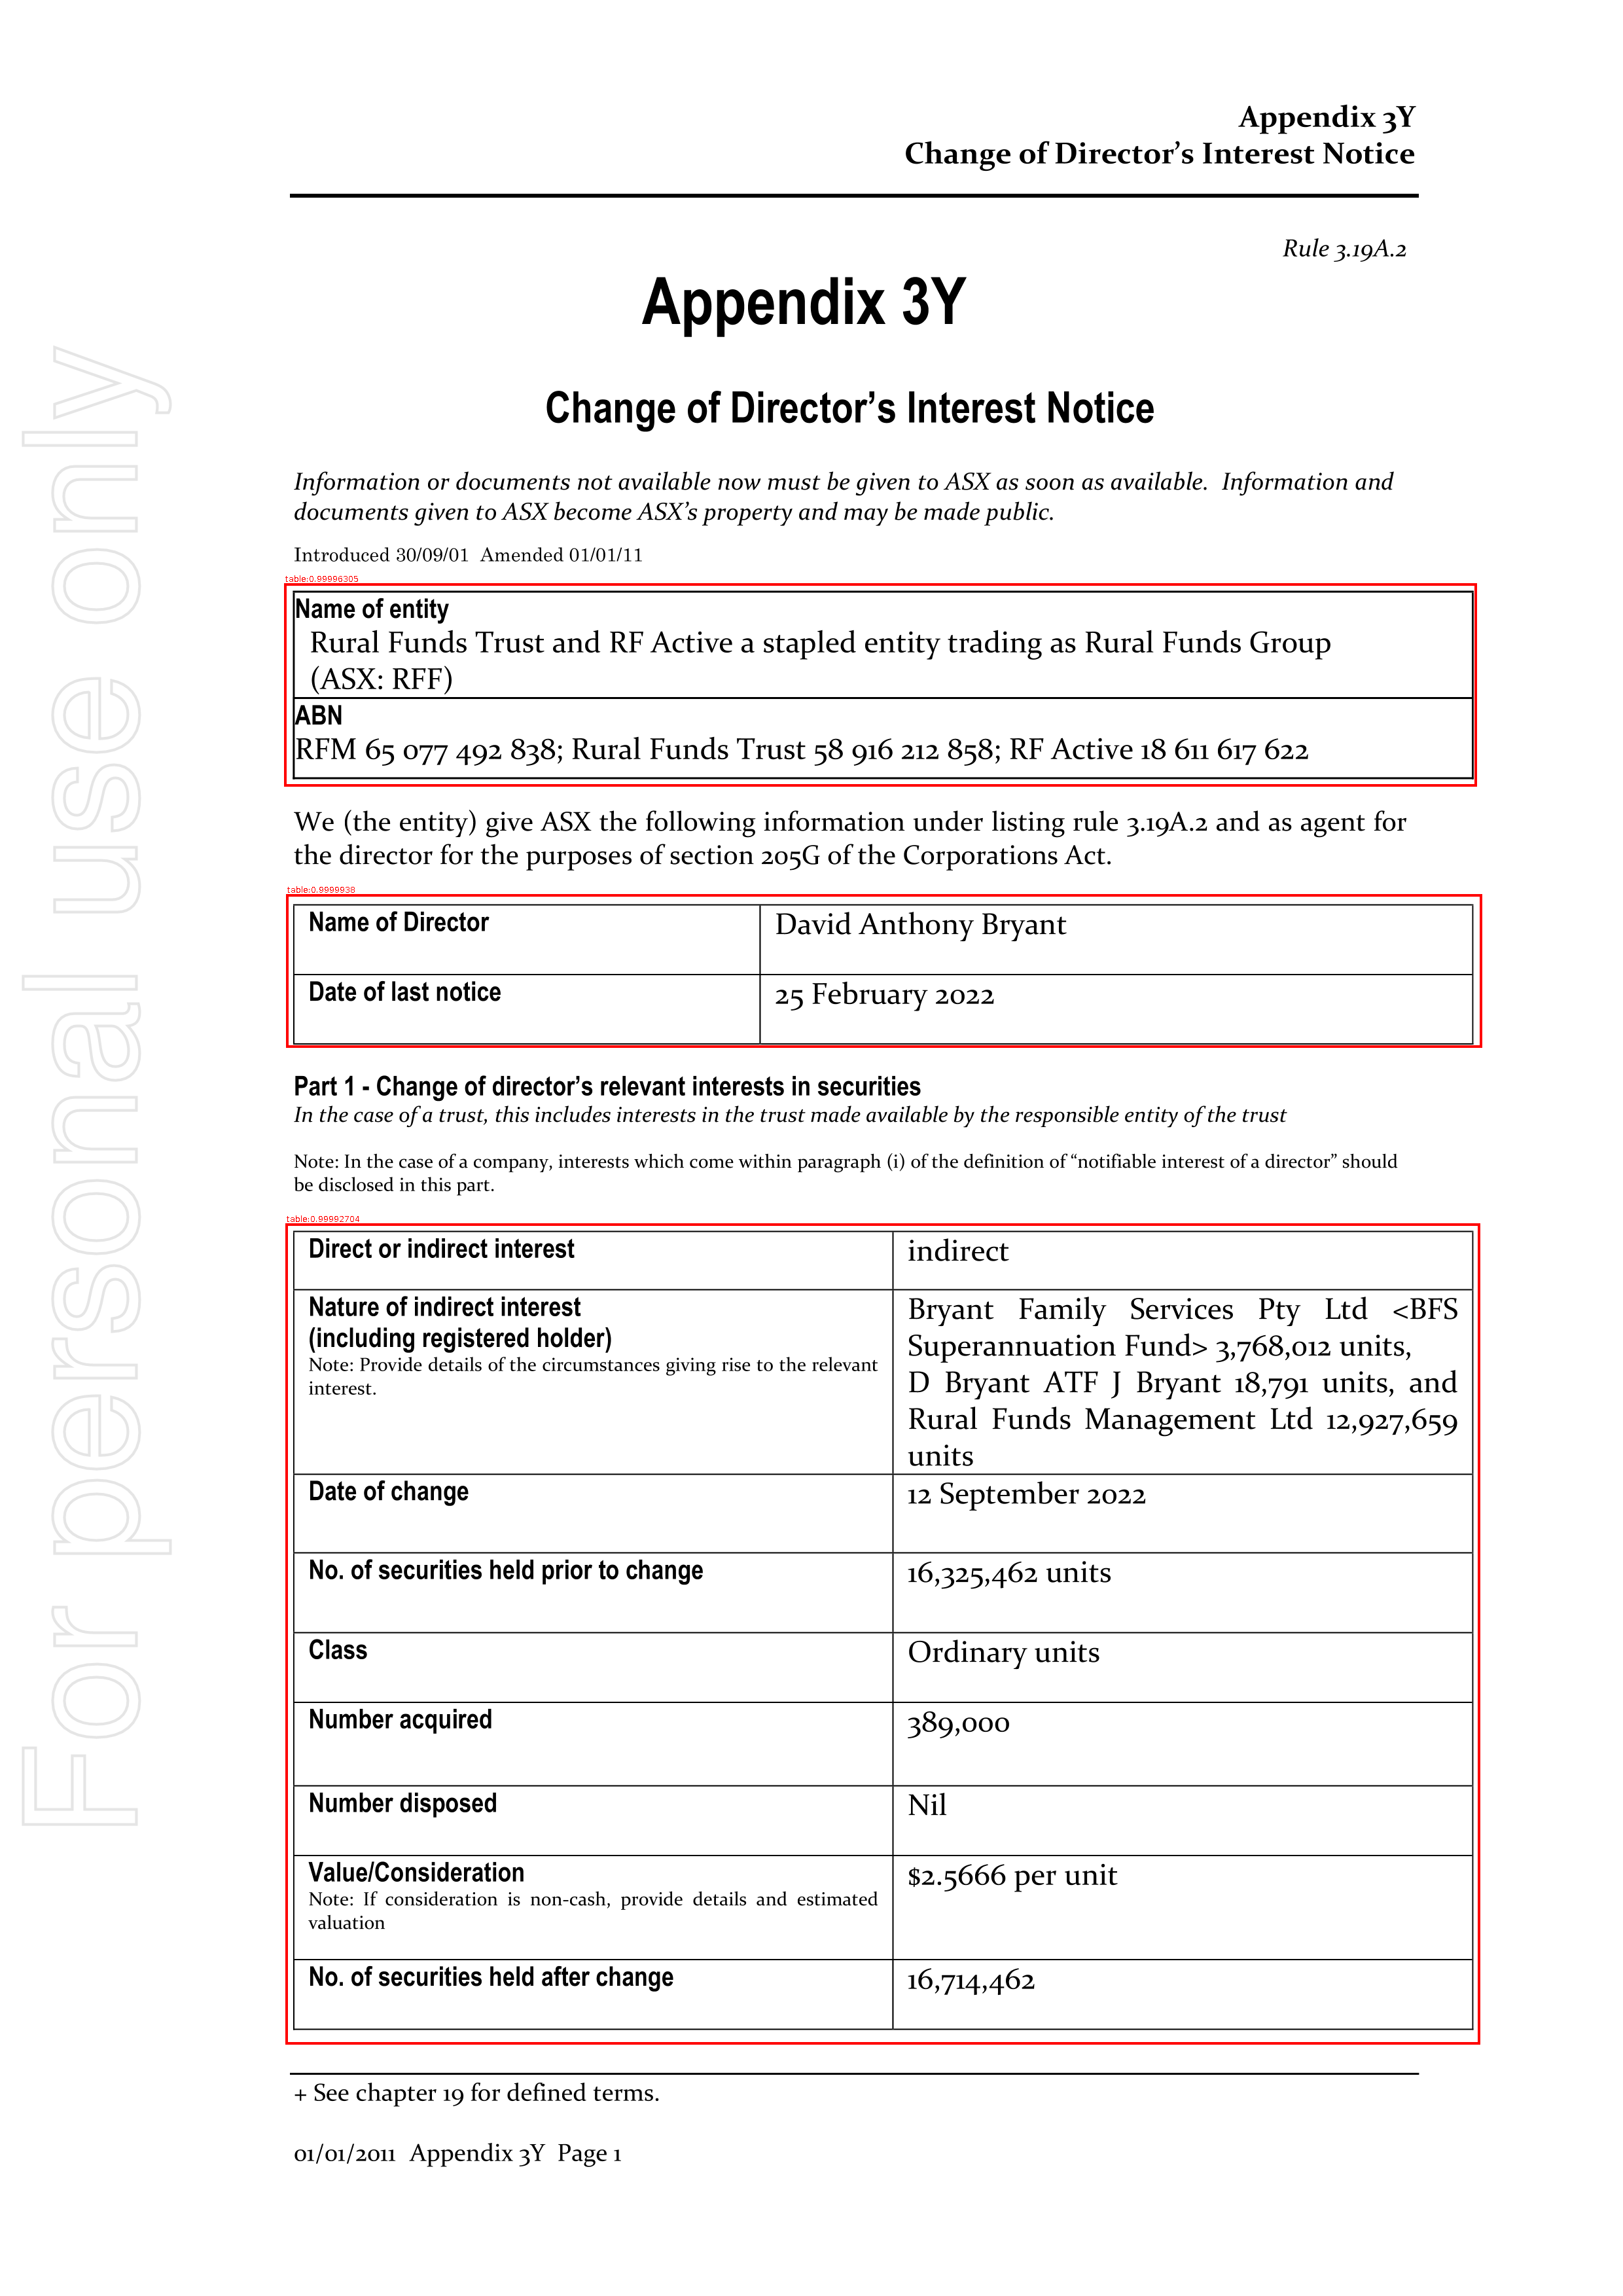


    Image #1:
    Origin: file:/home/jose/spark-ocr/workshop/webinars/financial/02567277.pdf
    Resolution: 0 dpi
    Width: 2480 px
    Height: 3508 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


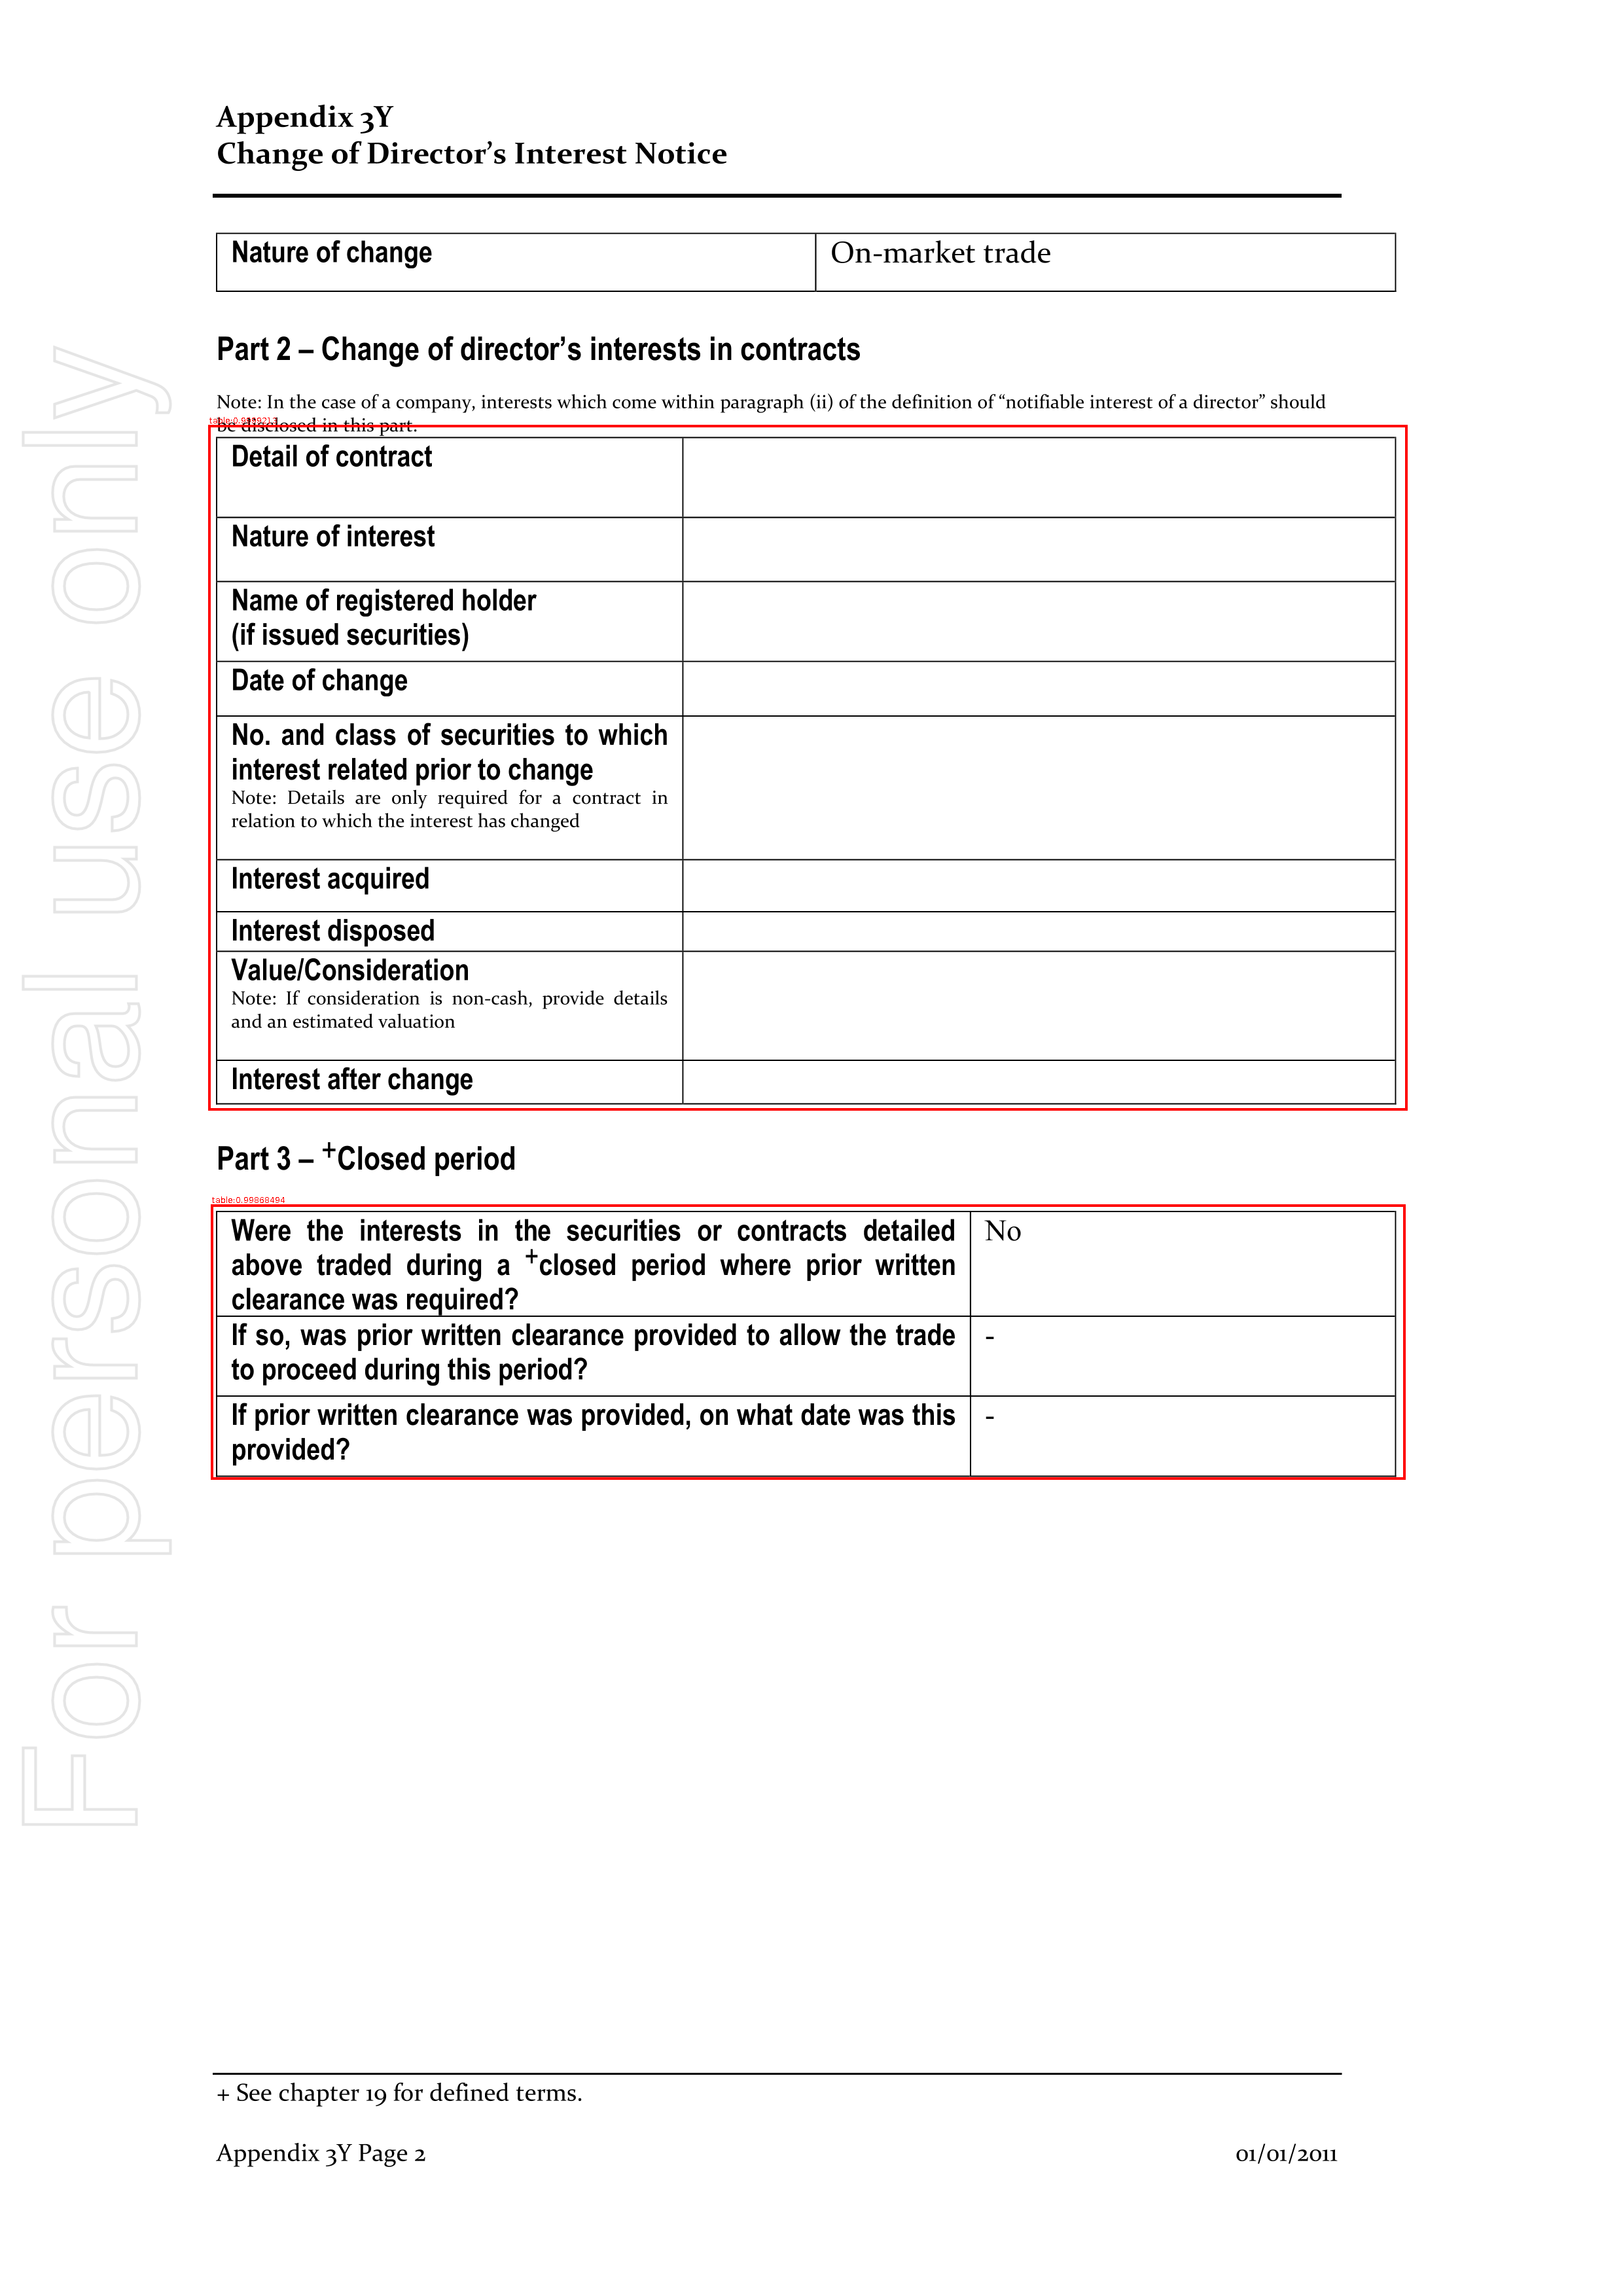

In [5]:
display_images(result.select("image_with_regions"), "image_with_regions")

### Question Answering Pipeline

In [6]:
from pyspark.sql.functions import col

# this is an issue in table detector
tables = result.filter(col('regions').isNotNull())
questions = ["What is the number of acquired units?",
             "What is the number of disposed units?",
             "What is the value per unit?"]

In [7]:
# Extract table regions to separate images
splitter = ImageSplitRegions() \
        .setInputCol("image") \
        .setInputRegionsCol("regions") \
        .setOutputCol("table_images") \
        .setExplodeCols(["regions"])

visual_question_answering = VisualQuestionAnswering()\
    .pretrained("docvqa_donut_base_opt", "en", "clinical/ocr")\
    .setQuestions(questions)\
    .setInputCol(['table_images']) \
    .setOutputCol("answers")



### Let's take a look at the tables

In [8]:
exploded = splitter.transform(tables)
exploded.select("table_images.height", "table_images.width").show()
exploded.count()

+------+-----+
|height|width|
+------+-----+
|   231| 1824|
|   307| 1819|
|  1251| 1822|
|  1044| 1829|
|   417| 1822|
+------+-----+



5

In [10]:
%%time
visual_question_answering.transform(exploded.repartition(6)).select("path", "answers").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------+
|col                                                                                                             |
+----------------------------------------------------------------------------------------------------------------+
| What is the number of acquired units? ->  25 february 2022                                                     |
| What is the number of disposed units? ->  25 february 2022                                                     |
| What is the value per unit? ->  2022                                                                           |
| What is the number of acquired units? ->  858                                                                  |
| What is the number of disposed units? ->  622                                                                  |
| What is the value per unit? ->  858                                           